# Advanced Tuning With Custom Training and Visualization

In our getting started notebook, [1_tuning_of_builtin_xgboost.ipynb](https://github.com/aws-samples/amazon-sagemaker-amt-visualize/blob/main/1_tuning_of_builtin_xgboost.ipynb) we dipped our feet into water and trained a single hyperparameter optimization (HPO) job with Amazon SageMaker Automatic Model Tuning (AMT). We trained and tuned a built-in XGBoost model provided by SageMaker Algorithms, meaning we did not need to provide our own training script. In the tuning stage, we ran a single HPO job with the bayesian search method as our HPO strategy.

But there is still much to learn about our hyperparamter space. AMT provides us with several strategies to sample values from this space, namely Grid, Random, Beyesian search and the Hyperband strategy. To illustrate the effect these strategies have on our HPO trials, we will run two identical HPO jobs, one using Bayesian and the other with the Random search strategy and we will compare the results side-by-side. 

Using the information we learned about our hyperparameter space from our first job, we will modify our parameter tuning ranges to explore more optimal regions of the space. With these newly defined parameter ranges, we will run a second HPO job. However we do not want our tuner to start completely from scratch. For more optimal and guided performance, we want to somehow reuse the information learned from our first HPO job, as a start point in our second. To do achieve this, we will use SageMaker AMT's warm start feature, by passing our previous HPO jobs as parents to our new HPO job. Our new HPO job will begin with an awareness of what values in our hyperparameter space were already explored by its parents, and which regions of this space were most promising. This knowledge will influence AMT's decision when selecting the hyperparameters for our HPO job and allow AMT to start with more optimital values earlier. We will see how trails ran with warm starting generally start with highly optimal values, when compared to trials without warm starts.

Additionally, we will take a step towards customizing our training, by replacing the SageMaker built-in algorithm with our own custom training script.

## Overview

This notebook is split into the following sections:
- Setup and Imports
- Load and Prepare dataset
- Train a Random Forest Classifier using a custom script with SageMaker Training
- Tune Hyperparameters with SageMaker AMT using Random & Bayesian strategies
- Review Results and Refine the search space
- Warmstarting

## Overview SageMaker **Training**

![Overview SageMaker Training](img/training_script_mode.png)

## Setup and Imports

In [58]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We ran this notebook using Amazon SageMaker with the version you see in the output of the next cell below. If your version is lower and you encounter issues, we recommend uncommenting the code below to upgrade your pip and SageMaker versions. Make sure to restart your kernel after upgrading for the changes to take effect.

In [59]:
import sagemaker

sagemaker.__version__ 

'2.116.0'

In [60]:
#!pip install --upgrade --quiet pip "sagemaker>=2.116.0" # upgrade SageMaker to the recommended version

In [61]:
import os
import pandas as pd
import numpy as np
import boto3
import sagemaker

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

In [35]:
# SDK setup
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sm = boto3.client('sagemaker')
boto_sess = boto3.Session(region_name=region)
sm_sess = sagemaker.session.Session(boto_session=boto_sess, sagemaker_client=sm)

In [62]:
# Data layout and locations. 
# To store our data we are using a prefix in the Amazon SageMaker default bucket. Feel free to adjust to your preferences.

BUCKET = sm_sess.default_bucket()
PREFIX = 'amt-visualize-demo' # REVIEW_AELLUL: Do we keep the same generalized prefix? We will overwrite data from other notebooks
s3_data_url = f's3://{BUCKET}/{PREFIX}/data'

## Load and Prepare dataset

In [37]:
!mkdir -p data

The focus of this notebook is on Hyperparameter Optimization. Hence the actual task and data only play a supporting role. But to give some brief context, we are optimizing the hyperparameters of a Random Forest model that should classify handwritten digits.

We use the Optical Recognition of Handwritten Digits Data Set via scikit-learn:

_Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

In [38]:
from sklearn import datasets

digits         = datasets.load_digits()
digits_df      = pd.DataFrame(digits.data)
digits_df['y'] = digits.target

digit: 4


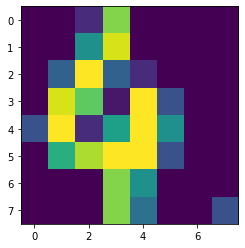

In [39]:
from matplotlib import pyplot as plt

print('digit:', int(digits_df.iloc[100].y))
plt.imshow(digits_df.iloc[100, 1:].values.reshape(8, -1));

In [44]:
digits_df.to_csv('data/digits.csv', index=False)

upload: data/digits.csv to s3://sagemaker-us-east-1-632581975302/amt-visualize-advanced-tuning/data/digits.csv


In [45]:
!aws s3 sync data/ {s3_data_url} --exclude '*' --include 'digits.csv'

## Preparing Training Scripts

Below we define our training script that we will pass on to SageMaker to run our training. Note that we chose to directly write the python file from the our Jupyter Notebook to the `src/` directory using the command `%%writefile src/train.py`. This is to make this sample more readable and keep all relevant code in one place in this notebook. 


### Dependencies and training containers 
When running our training, we often rely on some functions from other libraries and dependecies. In our case, we use functions from the `scikit-learn` and `pandas` libraries.

Luckily, SageMaker offers [several Frameworks](https://sagemaker.readthedocs.io/en/stable/frameworks/index.html) that come pre-installed with popular data science and ML frameworks such Scikit-learn, PyTorch and TensorFlow.

For our purposes in this notebook, we'll be using the [Scikit-learn Framework](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html#prepare-a-scikit-learn-training-script) that has everything we need for our training.

### (Optional) Defining a requirements.txt file
One common practice to collect and organise dependencies and external libraries in Python, is to define a `requirements.txt` file containing a list of imported libraries and their versions.

Although our Scikit-learn container provides us with all the libraries we need, if we needed access to libraries not included in the provided container, we could also define these in `requirements.txt`.

Defining a `requirements.txt` file is an optional step, and not required to launch SageMaker training but it is supported if you wish to include it. SageMaker will automatically scan our source directory containing our `train.py` for an additional `requirements.txt`. For more information, see the [documentation here](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html#using-third-party-libraries).

In [63]:
!mkdir -p src
import sys
sys.path.append('src')

In [64]:
%%writefile src/requirements.txt

# Not necessary for our training but we may define additional libraries as required
#[optional-additional-libraries]

Overwriting src/requirements.txt


In [48]:
%%writefile src/train.py

#!/usr/bin/env python
import argparse
import os
import traceback
from pathlib import Path

import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import joblib

def fit(train_dir, n_estimators, max_depth, min_samples_leaf, max_features, min_weight_fraction_leaf):
    
    digits = pd.read_csv(Path(train_dir)/'digits.csv')
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(digits.iloc[:, :-1], digits.iloc[:, -1], test_size=.2)
    
    m = RandomForestClassifier(n_estimators=n_estimators, 
                               max_depth=max_depth, 
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               min_weight_fraction_leaf=min_weight_fraction_leaf)
    m.fit(Xtrain, ytrain)
    predicted = m.predict(Xtest)
    pre, rec, f1, _ = precision_recall_fscore_support(ytest, predicted, pos_label=1, average='weighted')
    
    print(f'pre: {pre:5.3f} rec: {rec:5.3f} f1: {f1:5.3}')
    
    return m

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.

    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))

    parser.add_argument('--n-estimators', type=int, default=100)
    parser.add_argument('--max-depth', type=int, default=10)
    parser.add_argument('--min-samples-leaf', type=int, default=1)
    parser.add_argument('--max-features', type=str, default='auto')
    parser.add_argument('--min-weight-fraction-leaf', type=float, default=0.01)

    args, _ = parser.parse_known_args()
    trained_model = fit(train_dir=args.train, 
                        n_estimators=args.n_estimators, 
                        max_depth=args.max_depth,
                        min_samples_leaf=args.min_samples_leaf,
                        max_features=args.max_features,
                        min_weight_fraction_leaf=args.min_weight_fraction_leaf)
    
    joblib.dump(trained_model, os.path.join(args.model_dir, 'model.joblib'))   


Overwriting src/train.py


#### Test run our training script locally



Now that we have prepared our training script, let's quickly run it locally to check that it works. We call and run our training script directly from this notebook, which makes it possible to use Python Debugger and other utilities.

In [49]:
%%time
# Running the code from within the notebook. It would then be possible to use the Python Debugger, pdb.
from train import fit
fit('data', 100, 10, 1, 'auto', 0.01)

pre: 0.957 rec: 0.956 f1: 0.955
CPU times: user 267 ms, sys: 0 ns, total: 267 ms
Wall time: 326 ms


RandomForestClassifier(max_depth=10, min_weight_fraction_leaf=0.01)

We could also run it directly from the command line. Doing so would trigger the `if __name__ =='__main__':` statement in our script, to parse our command line arguments. When SageMaker loads our script into a container onto an EC2 instance, SageMaker will also launch our train.py via the command line.

In [50]:
!cd src && python train.py --train ../data/ --model-dir /tmp/ --n-estimators 100

pre: 0.968 rec: 0.967 f1: 0.967


## Run Training in Containers

With our `train.py` ready and tested, we are ready to create our estimator and call `fit()` to start our training.

### Define our metrics

Recall that in our first notebook, we used a built-in Algorithm for our training. This pre-built container and training script by SageMaker came already configured with its own metrics and metrics defintions. Since we are using a custom training script in this notebook, we now must specify our metrics to SageMaker.

In our `train.py`, we used `print(f'pre: {pre:5.3f} rec: {rec:5.3f} f1: {f1:5.3}')` to emit metrics from our training. During training, this information is printed to `std.out`, which is parsed by SageMaker and sent to Amazon CloudWatch.

In order for SageMaker to successfully parse our metrics, we must provide the Regular Expressions (REGEX), that instruct SageMaker how to extract the numerical values from our print statement above, as described [in the documentation here](https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html). We do this with our `metric_definitions` object below, which we then pass as a parameter to our estimator. 

_Note: The metrics we chose here will eventually be used by SageMaker AMT for our HPO jobs, more [information on tuning metrics can be found here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-metrics.html)

In [52]:
metric_definitions = [{'Name': 'Valid:Precision',  'Regex': r'pre:\s+(-?[0-9\.]+)'},
                      {'Name': 'Valid:Recall',     'Regex': r'rec:\s+(-?[0-9\.]+)'},
                      {'Name': 'Valid:F1',         'Regex': r'f1:\s+(-?[0-9\.]+)'}]                                 

In [ ]:
# FIXME: Some explanation how the container is selected.

from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

In [54]:
estimator = SKLearn(
    'train.py',
    source_dir='src',
    role=get_execution_role(),
    instance_type= 'ml.m5.large',
    instance_count=1,
    framework_version='0.23-1',
    metric_definitions=metric_definitions,

    use_spot_instances= True,
    max_run=  60 * 60 * 24,
    max_wait= 60 * 60 * 24,

    hyperparameters = {'n-estimators': 100,
                       'max-depth': 10,
                       'min-samples-leaf': 1,
                       'max-features': 'auto',
                       'min-weight-fraction-leaf': 0.1}
)

In [ ]:
print(s3_data_url)
estimator.fit({'train': s3_data_url}, wait=True)

s3://sagemaker-us-east-1-632581975302/amt-visualize-advanced-tuning/data
2022-11-18 15:38:21 Starting - Starting the training job...
2022-11-18 15:38:46 Starting - Preparing the instances for trainingProfilerReport-1668785901: InProgress
......
2022-11-18 15:39:46 Downloading - Downloading input data......
2022-11-18 15:40:46 Training - Downloading the training image..2022-11-18 15:41:02,220 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-11-18 15:41:02,224 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-18 15:41:02,232 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-11-18 15:41:02,664 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
2022-11-18 15:41:03,957 sagemaker-tra

---

## Overview SageMaker Automatic Model Tuning

Now we can explore more possible `hyperparameters` for the same `estimator` as we have used above. As shown on the diagram, we setup the `HyperparameterTuner` using our custom training script and launch HPO Job. This will initiate Training Jobs wth different hyperparameters from `hpt_ranges`. 

![Overview SageMaker Automatic Model Tuning](img/amt_script_mode.png)

### What is necessary to define for [`HyperparameterTuner`](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html)?

1. the ranges of hyperparameters

The hyperparameters are different from algorithm to algorithm. In our example we use scikit-learn implementation of Random Forest, so you can look into all its hyperparameters [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
The ranges are defined with the types of hyperparameter. There are three of them such as 
- categorical parameters that are defined in a concrete set
- continuous parameters with any real number values between the pre-defined minimal and maximal values
- integer parameters with any integer value between the minimum and maximum values. 
Additional information on hyperparameters structure and the step between them (scaling) can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-ranges.html).

2. the objective metric for the Tuning Job to optimize 

The metric is necessary for custom training code, a built-in SageMaker algorithm can use default values. You can check out [Define Metrics documentation page](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-ranges.html) to see the examples of metric definitions and HPO logs.  


3. the optimization strategy

How will the HPO job choose concrete hyperparameters? There are four strategies currently available that you can use for SageMaker AMT:
- Grid Search
- Random Search 
- Bayesian Optimization (default)
- Hyperband.

Let's look into their implementation and differences.


## Automatic Model Tuning Jobs - Grid Search

Grid Search helps us explore all possible combinations from the hyperparameter ranges. We define those ranges in categorical parameters and the maximum number of jobs is determined through the number of various combinations. This search is the closest one to manual search that is performed when choosing concrete values for hyperparameters. It works better for few components, when HPO job has lower degree of dimensionality from the number of hyperparameters to optimize.

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner


categorical_hpt_ranges = {'n-estimators': CategoricalParameter([1, 100, 200]),
              'max-depth': CategoricalParameter([1, 10, 20]), 
              'min-samples-leaf': CategoricalParameter([1, 5, 10]),
              'min-weight-fraction-leaf': CategoricalParameter([0.01, 0,25, 0.5]),
              'max-features': CategoricalParameter(['auto', 'log2', 'sqrt'])}


tuner_parameters = {'estimator': estimator,
                    'base_tuning_job_name': 'grid',
                    'metric_definitions': metric_definitions,
                    
                    'objective_metric_name': 'Valid:F1',
                    'objective_type': 'Maximize',
                    'hyperparameter_ranges': categorical_hpt_ranges,
                    'strategy': 'Grid',
                    'max_jobs': 324}  # defined as the maximal number of possible combinations

In [ ]:
grid_tuner = HyperparameterTuner(**tuner_parameters)
grid_tuner.fit({'train': s3_data_url}, wait=False)
grid_tuner_name = grid_tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {grid_tuner_name}.')

## Automatic Model Tuning Jobs - Random Search

With Random Search we can define `hpt_ranges` in continuous manner and AMT will choose the random combinations. This strategy normally has lower complexity of computation compared to Grid Search and it can be controlled through defining the maximum number of trials (`max_jobs`) and the number of workers for parallelization (`max_parallel_jobs`).

In [17]:
hpt_ranges = {'n-estimators': IntegerParameter(1, 200),
              'max-depth': IntegerParameter(1, 20), 
              'min-samples-leaf': IntegerParameter(1, 10),
              'min-weight-fraction-leaf': ContinuousParameter(0.01, 0.5),
              'max-features': CategoricalParameter(['auto', 'log2', 'sqrt'])}

n = 30
k = 2

tuner_parameters['strategy']             = 'Random'
tuner_parameters['base_tuning_job_name'] = 'random'
tuner_parameters['hyperparameter_ranges'] = hpt_ranges
tuner_parameters['max_jobs'] = n
tuner_parameters['max_parallel_jobs'] = k  # With 'random' we could use a much higher parallelization here, 
                                            # as all trials/jobs are independent

tuner_parameters = {'estimator': estimator,
                    'base_tuning_job_name': 'random',
                    'metric_definitions': metric_definitions,
                    
                    'objective_metric_name': 'Valid:F1',
                    'objective_type': 'Maximize',
                    'hyperparameter_ranges': hpt_ranges,
                    'strategy': 'Random',
                    
                    'max_jobs': n,
                    'max_parallel_jobs': k} 

In [18]:
random_tuner = HyperparameterTuner(**tuner_parameters)
random_tuner.fit({'train': s3_data_url}, wait=False)
random_tuner_name = random_tuner.describe()['HyperParameterTuningJobName']
print(f'tuning job submitted: {random_tuner_name}.')

tuning job submitted: random-221114-1202.


## Automatic Model Tuning Jobs - Bayesian Optimization

Bayesian Optimization treats optimization as a regression problem and takes into account the past evaluation outcomes of each run to sample new candidates that are more likely to optimize the objective metric, thus, trying to arrive at optimised set of hyperparameters as soon as possible.

In [19]:
tuner_parameters['strategy']             = 'Bayesian'
tuner_parameters['base_tuning_job_name'] = 'bayesian'

In [20]:
bayesian_tuner = HyperparameterTuner(**tuner_parameters)
bayesian_tuner.fit({'train': s3_data_url}, wait=False)
bayesian_tuner_name = bayesian_tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {bayesian_tuner_name}.')

tuning job submitted: bayesian-221114-1202.


In [21]:
grid_tuner.wait()
random_tuner.wait()
bayesian_tuner.wait()

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
..........!


## Review Results

In [22]:
from amtviz import visualize_tuning_job

In [23]:
tuning_jobs = [grid_tuner, random_tuner, bayesian_tuner]

### Random

Tuning job random-221114-1202        status: Completed

Number of training jobs with valid objective: 30
Lowest: 0.12600000202655792 Highest 0.9160000085830688


,max-depth,max-features,min-samples-leaf,min-weight-fraction-leaf,n-estimators,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,Valid:F1
3,15.0,auto,9.0,0.050965,82.0,random-221114-1202-027-ec778ab0,Completed,2022-11-14 12:42:53+01:00,2022-11-14 12:44:10+01:00,77.0,random-221114-1202,0.916
18,8.0,sqrt,5.0,0.110700,67.0,random-221114-1202-012-181fe6f3,Completed,2022-11-14 12:18:42+01:00,2022-11-14 12:19:54+01:00,72.0,random-221114-1202,0.863
7,14.0,auto,1.0,0.108728,34.0,random-221114-1202-023-d219a3f5,Completed,2022-11-14 12:36:52+01:00,2022-11-14 12:38:09+01:00,77.0,random-221114-1202,0.829
20,14.0,sqrt,9.0,0.218122,16.0,random-221114-1202-010-cda752b5,Completed,2022-11-14 12:15:39+01:00,2022-11-14 12:16:51+01:00,72.0,random-221114-1202,0.824
25,20.0,auto,6.0,0.159646,57.0,random-221114-1202-005-f814bb0a,Completed,2022-11-14 12:10:04+01:00,2022-11-14 12:11:37+01:00,93.0,random-221114-1202,0.805
9,20.0,log2,1.0,0.167947,152.0,random-221114-1202-021-d7a6643a,Completed,2022-11-14 12:33:46+01:00,2022-11-14 12:35:03+01:00,77.0,random-221114-1202,0.805
26,5.0,auto,10.0,0.187444,61.0,random-221114-1202-004-6761a6b6,Completed,2022-11-14 12:07:09+01:00,2022-11-14 12:08:21+01:00,72.0,random-221114-1202,0.805
24,5.0,log2,3.0,0.260753,31.0,random-221114-1202-006-fea5de16,Completed,2022-11-14 12:10:04+01:00,2022-11-14 12:11:20+01:00,76.0,random-221114-1202,0.789
8,4.0,log2,8.0,0.474309,180.0,random-221114-1202-022-72557991,Completed,2022-11-14 12:33:47+01:00,2022-11-14 12:34:59+01:00,72.0,random-221114-1202,0.785
21,3.0,sqrt,7.0,0.095629,37.0,random-221114-1202-009-705a6c29,Completed,2022-11-14 12:15:39+01:00,2022-11-14 12:16:55+01:00,76.0,random-221114-1202,0.763


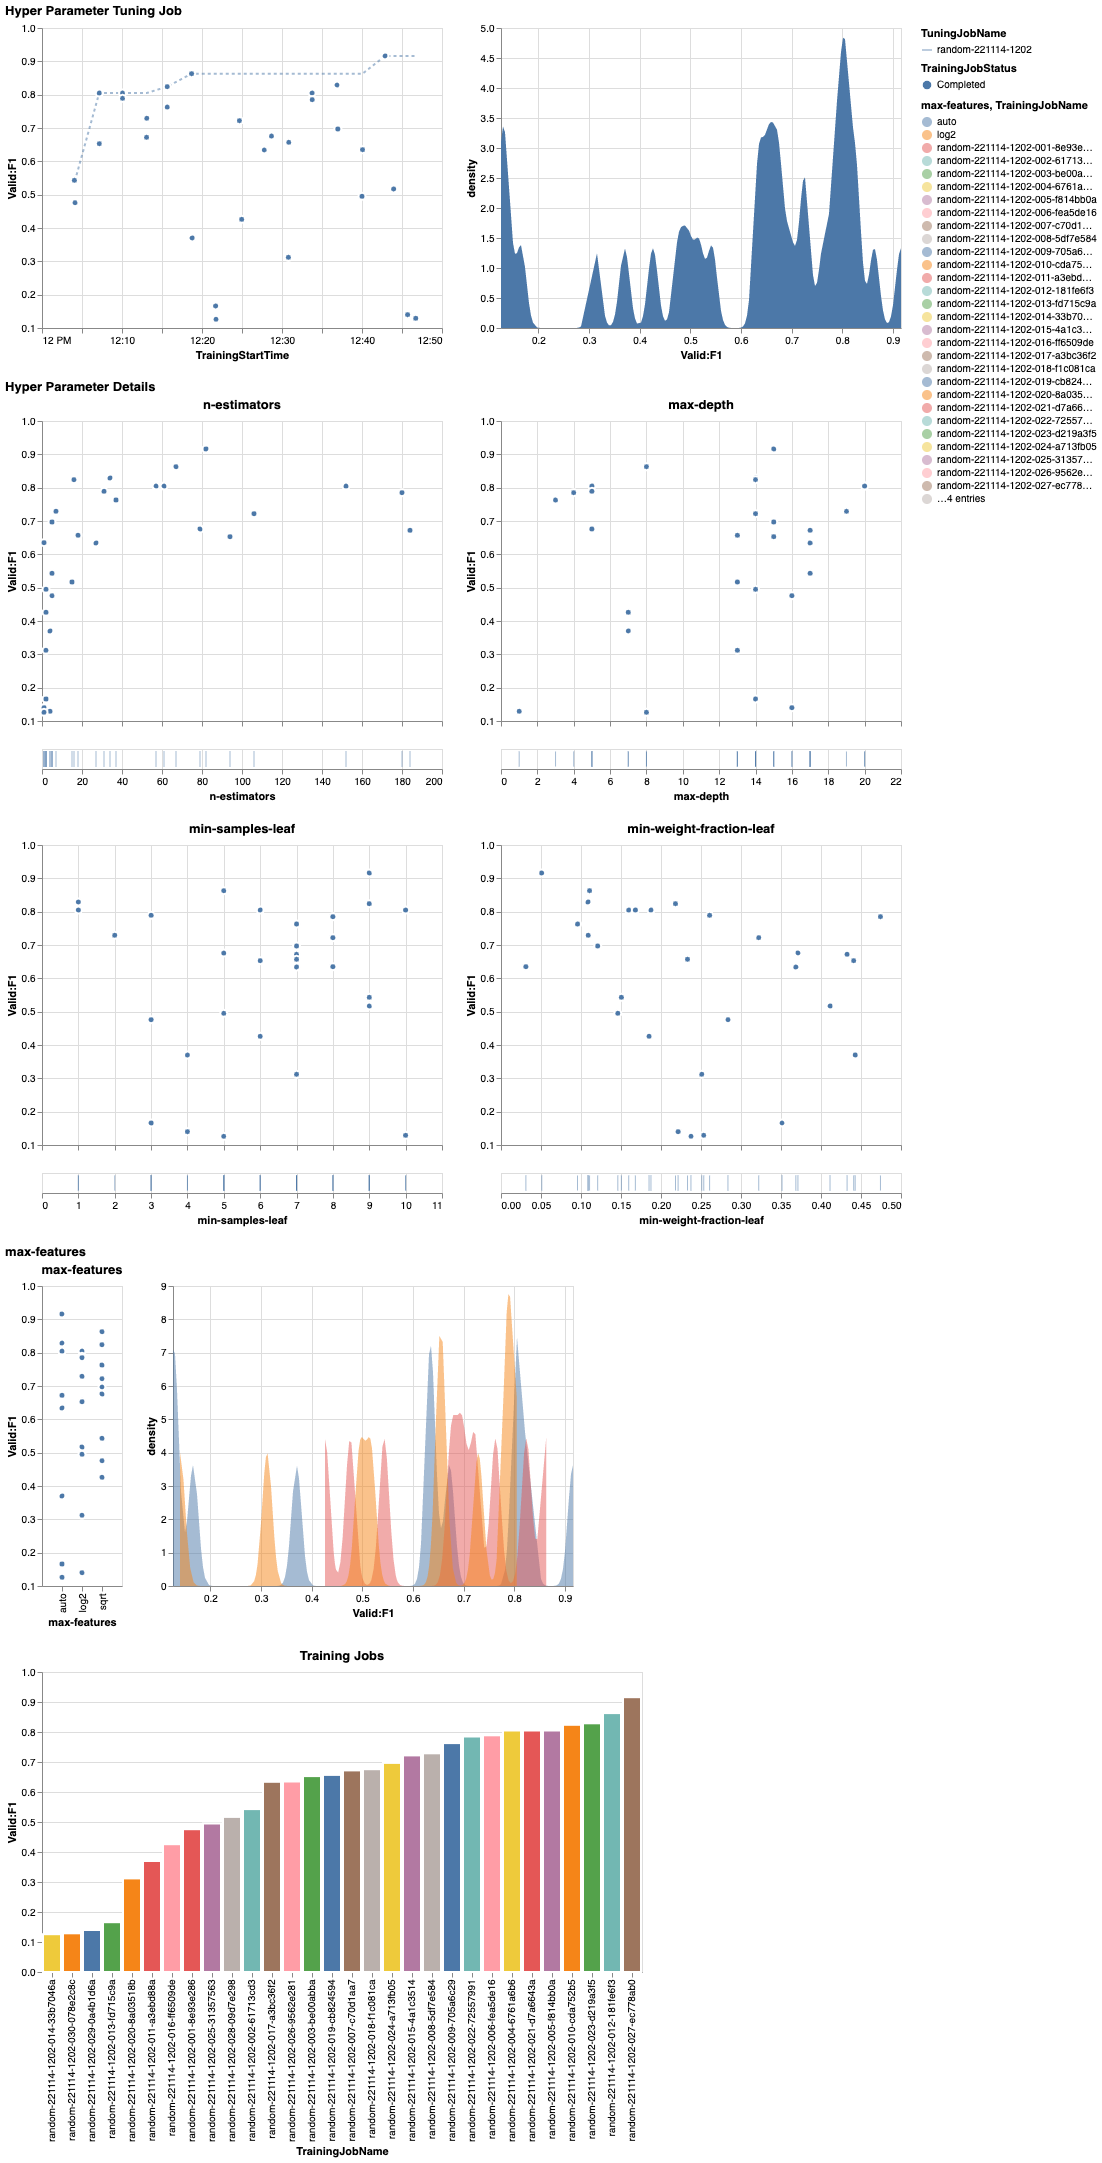

In [24]:
visualize_tuning_job(random_tuner, advanced=True, trials_only=True)

### Bayesian

Tuning job bayesian-221114-1202      status: Completed

Number of training jobs with valid objective: 30
Lowest: 0.01119999960064888 Highest 0.9580000042915344


,max-depth,max-features,min-samples-leaf,min-weight-fraction-leaf,n-estimators,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,Valid:F1
4,17.0,auto,7.0,0.010000,68.0,bayesian-221114-1202-026-54894975,Completed,2022-11-14 12:41:48+01:00,2022-11-14 12:42:59+01:00,71.0,bayesian-221114-1202,0.958
3,20.0,sqrt,4.0,0.010000,76.0,bayesian-221114-1202-027-de5aad13,Completed,2022-11-14 12:44:25+01:00,2022-11-14 12:45:47+01:00,82.0,bayesian-221114-1202,0.950
2,20.0,log2,4.0,0.010000,200.0,bayesian-221114-1202-028-b6dcefe5,Completed,2022-11-14 12:44:30+01:00,2022-11-14 12:45:47+01:00,77.0,bayesian-221114-1202,0.942
15,20.0,log2,5.0,0.010000,12.0,bayesian-221114-1202-015-6546d095,Completed,2022-11-14 12:26:13+01:00,2022-11-14 12:27:35+01:00,82.0,bayesian-221114-1202,0.939
5,12.0,log2,5.0,0.010000,45.0,bayesian-221114-1202-025-874812d9,Completed,2022-11-14 12:41:40+01:00,2022-11-14 12:42:51+01:00,71.0,bayesian-221114-1202,0.936
18,19.0,sqrt,6.0,0.010000,9.0,bayesian-221114-1202-012-05c35923,Completed,2022-11-14 12:19:20+01:00,2022-11-14 12:21:08+01:00,108.0,bayesian-221114-1202,0.930
16,9.0,log2,9.0,0.018002,200.0,bayesian-221114-1202-014-82e21063,Completed,2022-11-14 12:22:58+01:00,2022-11-14 12:24:42+01:00,104.0,bayesian-221114-1202,0.928
0,20.0,log2,6.0,0.021072,14.0,bayesian-221114-1202-030-d6ef341e,Completed,2022-11-14 12:47:40+01:00,2022-11-14 12:48:52+01:00,72.0,bayesian-221114-1202,0.927
8,7.0,auto,1.0,0.010000,12.0,bayesian-221114-1202-022-d8e02a2a,Completed,2022-11-14 12:35:26+01:00,2022-11-14 12:36:43+01:00,77.0,bayesian-221114-1202,0.908
13,19.0,sqrt,1.0,0.032823,10.0,bayesian-221114-1202-017-3f97b1fc,Completed,2022-11-14 12:29:31+01:00,2022-11-14 12:30:33+01:00,62.0,bayesian-221114-1202,0.905


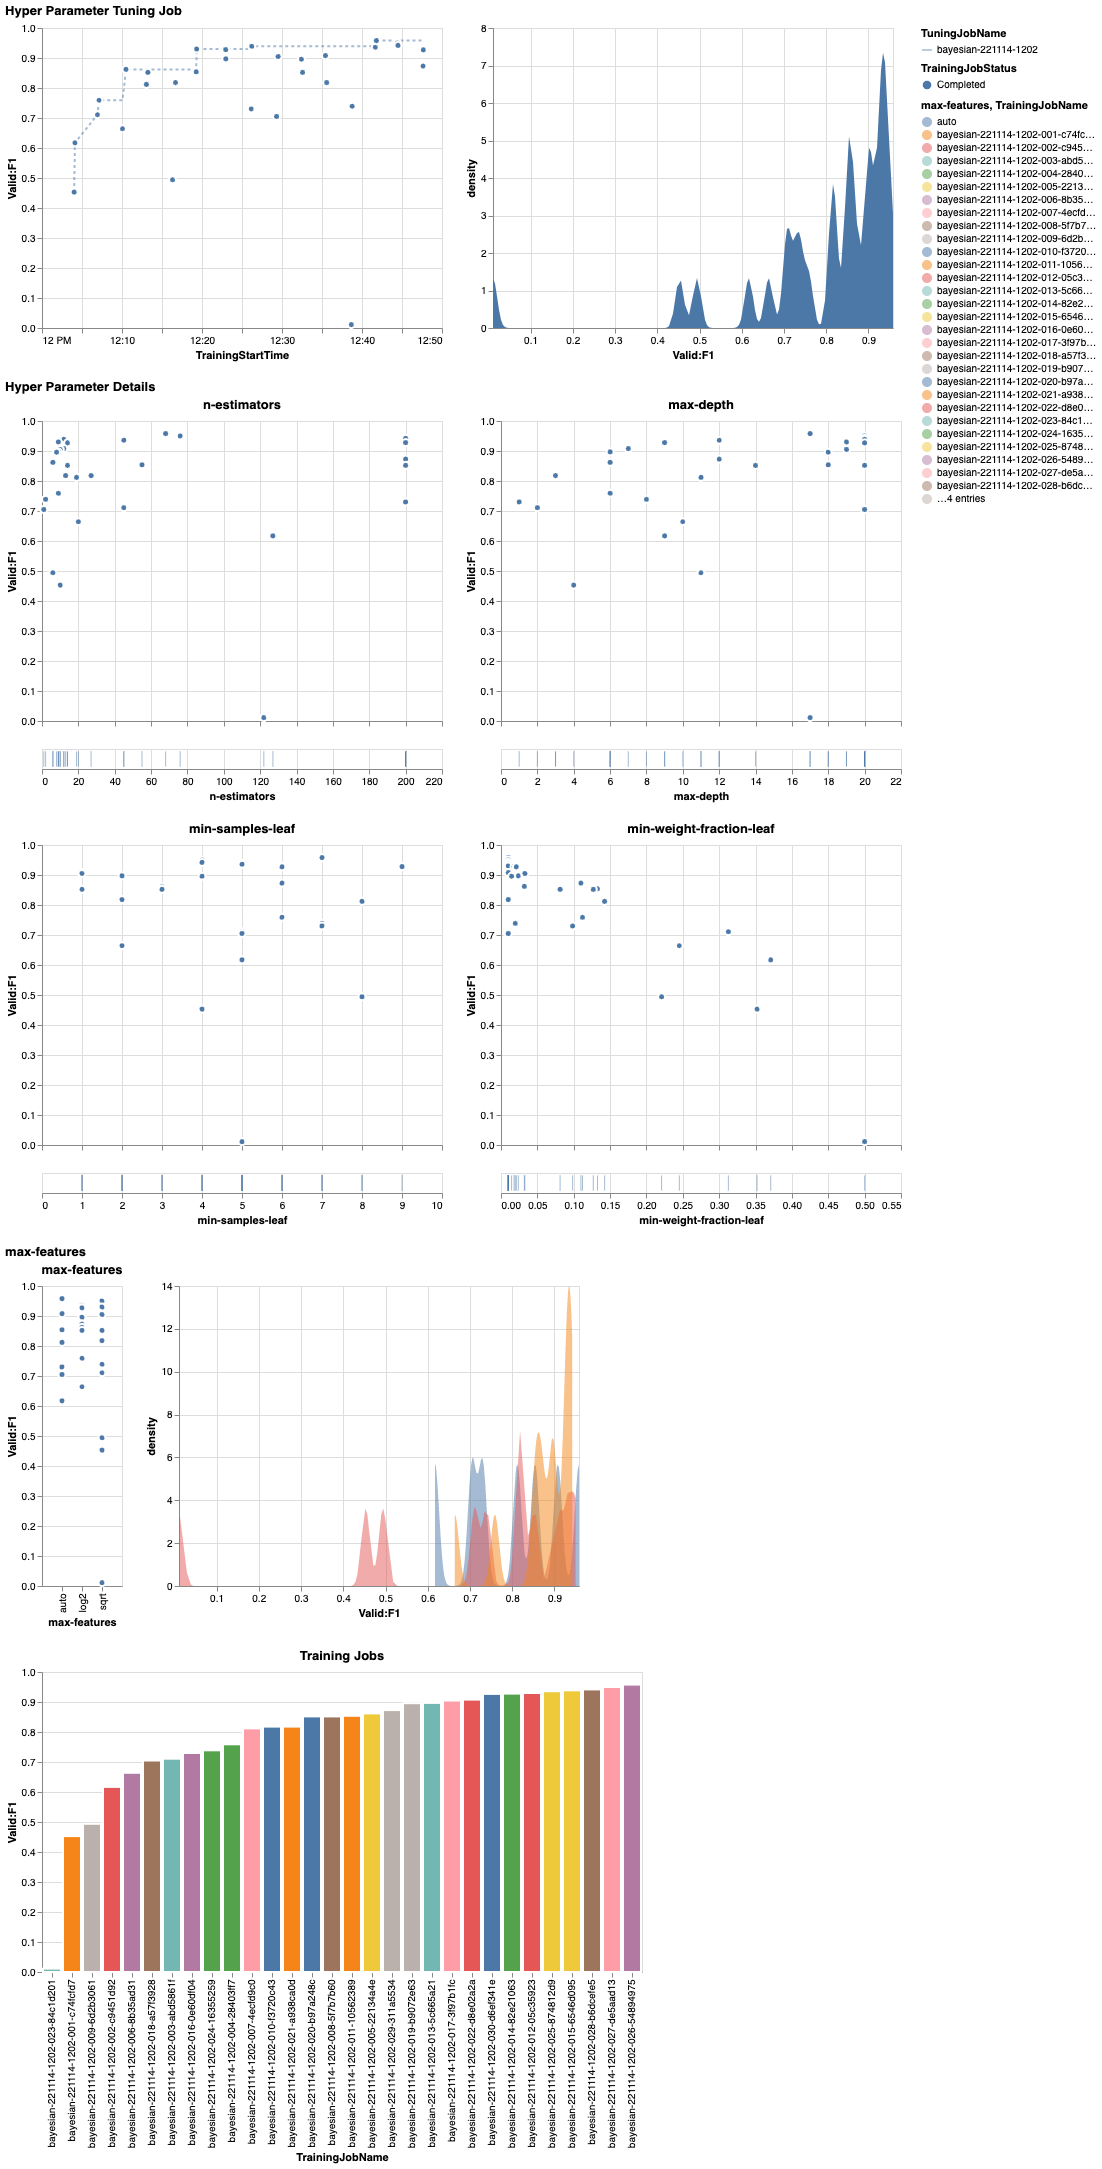

In [25]:
visualize_tuning_job(bayesian_tuner, advanced=True, trials_only=True)

### Both

Tuning job random-221114-1202        status: Completed
Tuning job bayesian-221114-1202      status: Completed

Number of training jobs with valid objective: 60
Lowest: 0.01119999960064888 Highest 0.9580000042915344


,max-depth,max-features,min-samples-leaf,min-weight-fraction-leaf,n-estimators,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,Valid:F1
4,17.0,auto,7.0,0.010000,68.0,bayesian-221114-1202-026-54894975,Completed,2022-11-14 12:41:48+01:00,2022-11-14 12:42:59+01:00,71.0,bayesian-221114-1202,0.958
3,20.0,sqrt,4.0,0.010000,76.0,bayesian-221114-1202-027-de5aad13,Completed,2022-11-14 12:44:25+01:00,2022-11-14 12:45:47+01:00,82.0,bayesian-221114-1202,0.950
2,20.0,log2,4.0,0.010000,200.0,bayesian-221114-1202-028-b6dcefe5,Completed,2022-11-14 12:44:30+01:00,2022-11-14 12:45:47+01:00,77.0,bayesian-221114-1202,0.942
15,20.0,log2,5.0,0.010000,12.0,bayesian-221114-1202-015-6546d095,Completed,2022-11-14 12:26:13+01:00,2022-11-14 12:27:35+01:00,82.0,bayesian-221114-1202,0.939
5,12.0,log2,5.0,0.010000,45.0,bayesian-221114-1202-025-874812d9,Completed,2022-11-14 12:41:40+01:00,2022-11-14 12:42:51+01:00,71.0,bayesian-221114-1202,0.936
18,19.0,sqrt,6.0,0.010000,9.0,bayesian-221114-1202-012-05c35923,Completed,2022-11-14 12:19:20+01:00,2022-11-14 12:21:08+01:00,108.0,bayesian-221114-1202,0.930
16,9.0,log2,9.0,0.018002,200.0,bayesian-221114-1202-014-82e21063,Completed,2022-11-14 12:22:58+01:00,2022-11-14 12:24:42+01:00,104.0,bayesian-221114-1202,0.928
0,20.0,log2,6.0,0.021072,14.0,bayesian-221114-1202-030-d6ef341e,Completed,2022-11-14 12:47:40+01:00,2022-11-14 12:48:52+01:00,72.0,bayesian-221114-1202,0.927
3,15.0,auto,9.0,0.050965,82.0,random-221114-1202-027-ec778ab0,Completed,2022-11-14 12:42:53+01:00,2022-11-14 12:44:10+01:00,77.0,random-221114-1202,0.916
8,7.0,auto,1.0,0.010000,12.0,bayesian-221114-1202-022-d8e02a2a,Completed,2022-11-14 12:35:26+01:00,2022-11-14 12:36:43+01:00,77.0,bayesian-221114-1202,0.908


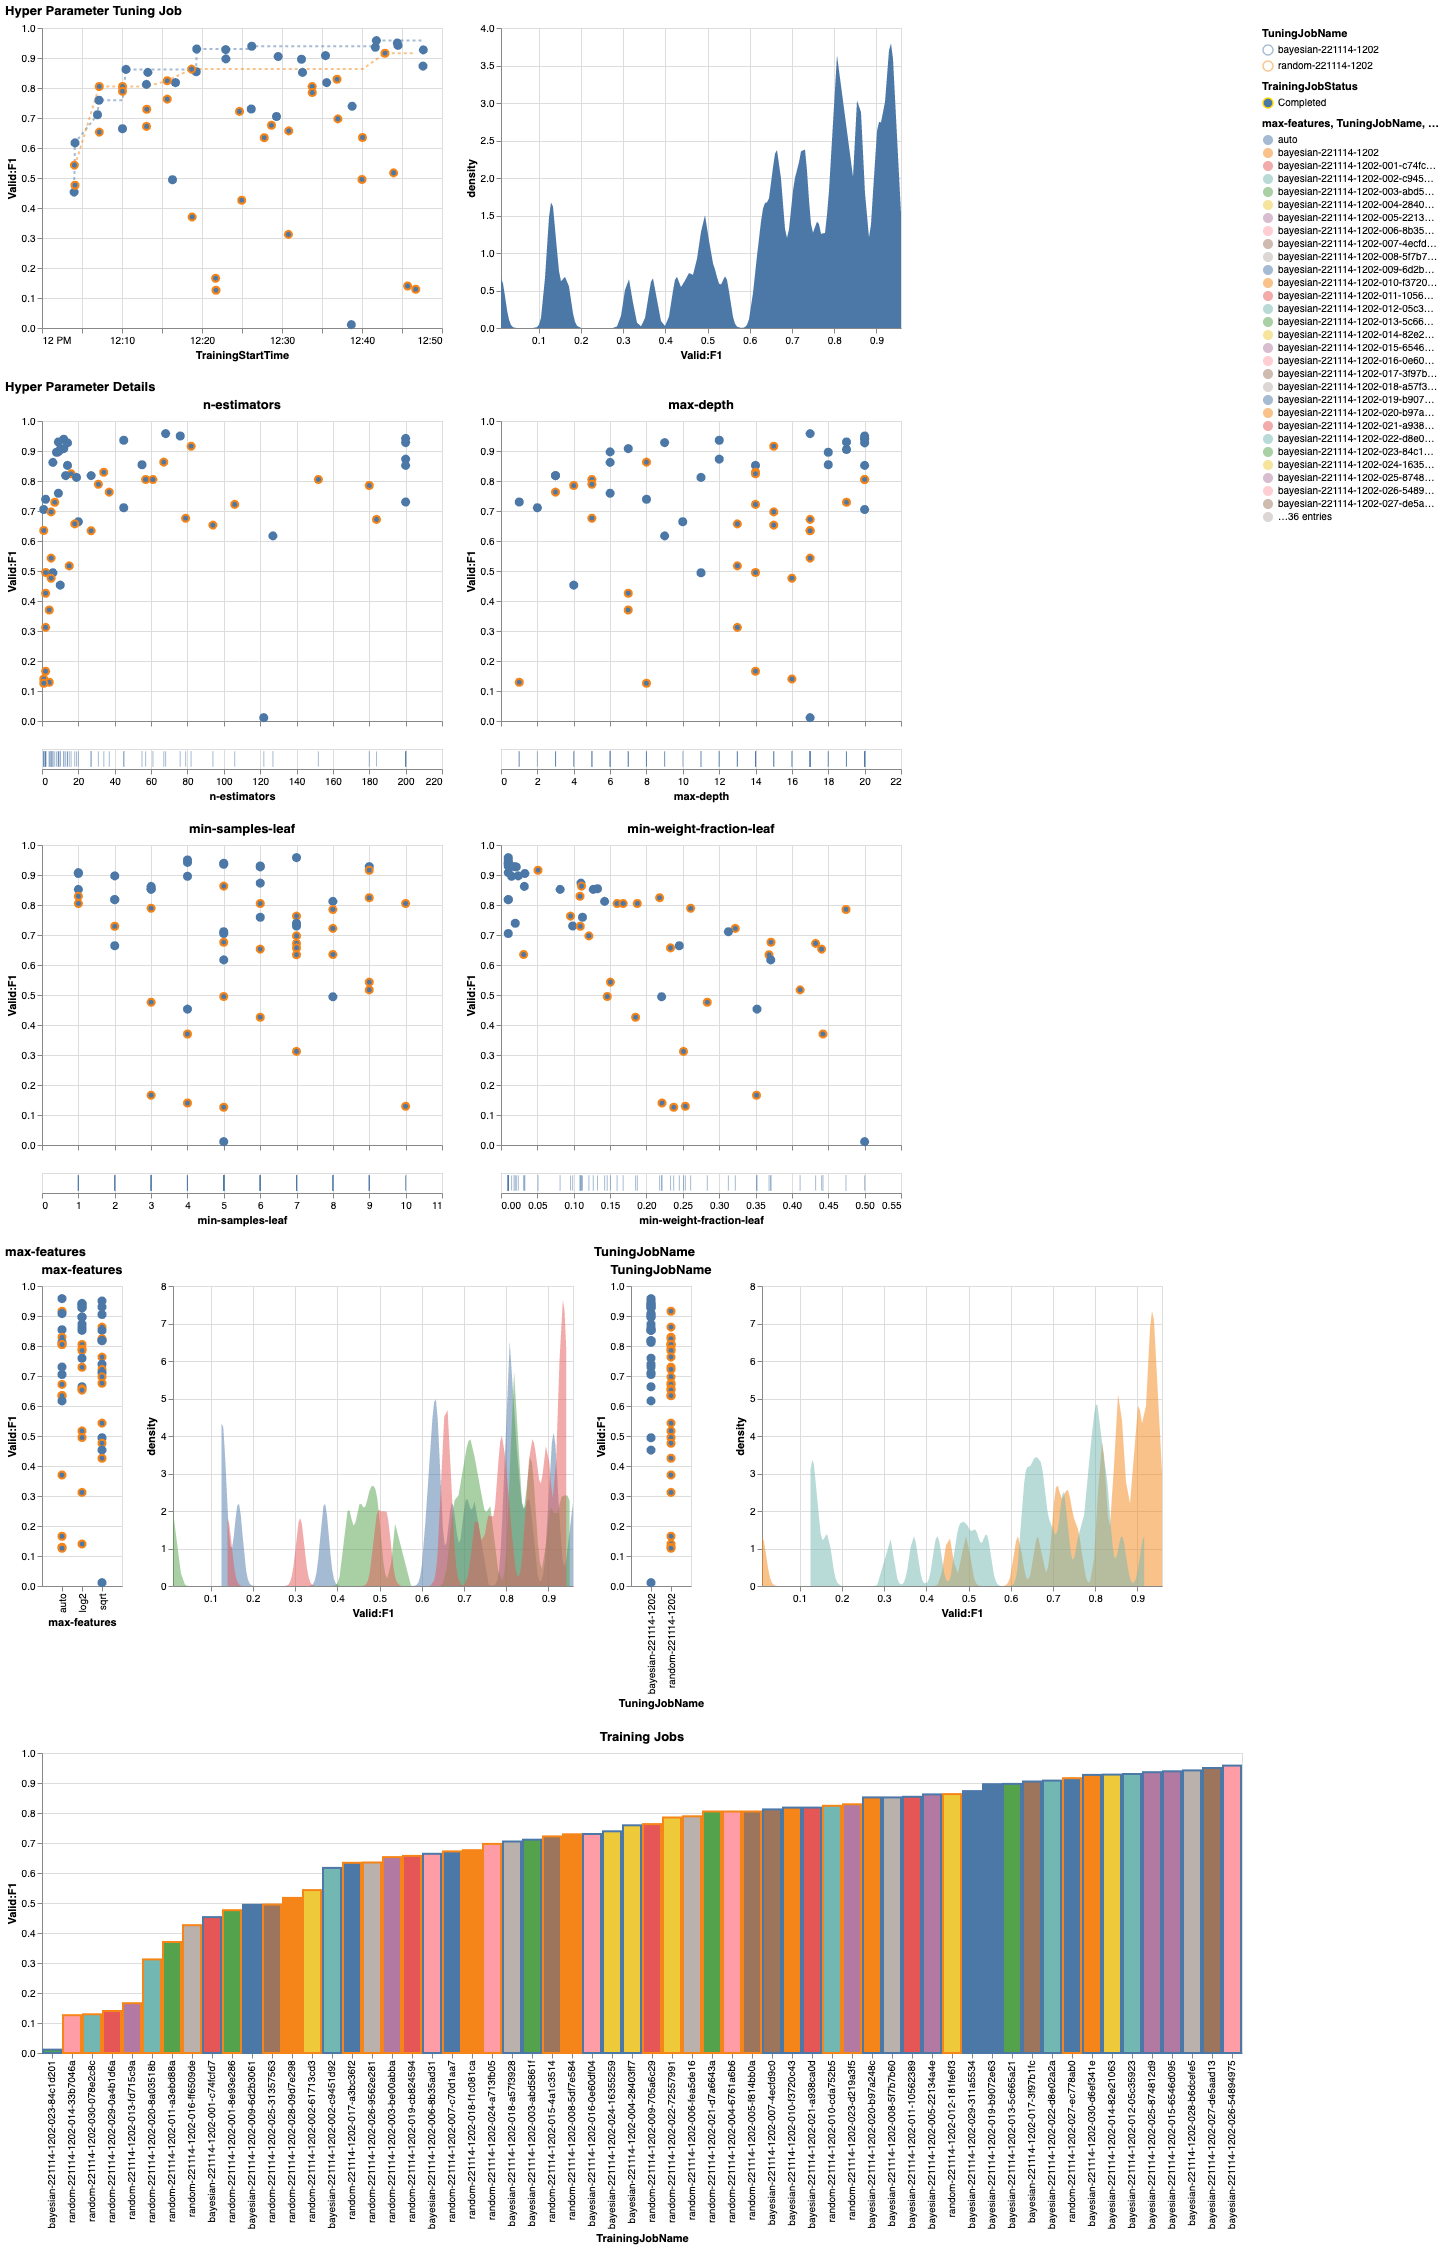

In [26]:
visualize_tuning_job(tuning_jobs, advanced=True, trials_only=True)

## Warmstart HPO Job

Let's now use our better understanding of good hyperparameter value ranges to do more searching. But we do not start from scratch, but [warmstart](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_HyperParameterTuningJobWarmStartConfig.html) a new HPO Job, that incorporates what was learned during the previous HPO run. Thus, we can continue optimizing our model from the point where the previous tuning experiment has finished.

To warm start we specify 2 parameters:
1. the list of parent tuning jobs (with the maximum of 5)
2. the type of Warm Start configuration 

- `IDENTICAL_DATA_AND_ALGORITHM` uses the same task and algorithm and starts jobs with previous evaluations from parent jobs but allows for changes in search space
- `TRANSFER_LEARNING` uses the evaluations from parent jobs, however, we can change search space, dataset or algorithm image.

We set `IDENTICAL_DATA_AND_ALGORITHM` as our `warm_start_type` since we don't change the training algorithm. More information on Warm Start HPO Job Types and restrictions can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-warm-start.html).

We can compare our range definitions side-by-side to see in what direction we should point our Warmstarted HPO Job. Check the comments below!

In [27]:
from sagemaker.tuner import WarmStartConfig, WarmStartTypes

warm_start_config = WarmStartConfig(warm_start_type=WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM, 
                                    parents=[bayesian_tuner_name, random_tuner_name]) # Recognize how we point to the previous tuning jobs (both Bayesian and Random)
tuner_parameters['warm_start_config'] =  warm_start_config

# repeated from above, then adjusted based on the runs from above. This is just an illustration, YMMV.
hpt_ranges = {'n-estimators': IntegerParameter(100, 300), # was (1,200). Many of the good values fell onto 200, maybe more is better?
              'max-depth': IntegerParameter(6, 24), # was (1, 20). Many of the good values fell on 20. Maybe more is better?
              'min-samples-leaf': IntegerParameter(1, 6), # was (1, 10) But there were not additional gains above 6.
              'min-weight-fraction-leaf': ContinuousParameter(0.001, 0.15), # was (0.01, 0.5)
              'max-features': CategoricalParameter(['auto', 'log2', 'sqrt'])} # unchanged. Inconclusive with the wide value ranges we searched. 
                                                                              # So let's try again with the narrower search from above.
tuner_parameters['hyperparameter_ranges'] = hpt_ranges
tuner_parameters['base_tuning_job_name'] = 'bayesian-warm'
tuner_parameters['max_jobs'] = n//2 # we can reduce the number of trials, as we already build on what we learned already
tuner_parameters['max_parallel_jobs'] = 1

warmstarted_tuner = HyperparameterTuner(**tuner_parameters)
warmstarted_tuner.fit({'train': s3_data_url}, wait=False)
warmstarted_tuner_name = warmstarted_tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {warmstarted_tuner_name}.')

tuning job submitted: bayesian-warm-221114-1249.


In [28]:
warmstarted_tuner.wait()

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


Tuning job bayesian-warm-221114-1249's parents: random-221114-1202, bayesian-221114-1202
Tuning job bayesian-warm-221114-1249 status: Completed
Tuning job random-221114-1202        status: Completed
Tuning job bayesian-221114-1202      status: Completed

Number of training jobs with valid objective: 75
Lowest: 0.01119999960064888 Highest 0.9919999837875366


,max-depth,max-features,min-samples-leaf,min-weight-fraction-leaf,n-estimators,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,Valid:F1
0,13.0,sqrt,3.0,0.001738,288.0,bayesian-warm-221114-1249-015-b7fbc51e,Completed,2022-11-14 13:34:46+01:00,2022-11-14 13:35:58+01:00,72.0,bayesian-warm-221114-1249,0.992
10,13.0,log2,6.0,0.001735,298.0,bayesian-warm-221114-1249-005-4585fe09,Completed,2022-11-14 13:02:42+01:00,2022-11-14 13:03:59+01:00,77.0,bayesian-warm-221114-1249,0.975
11,24.0,auto,2.0,0.001062,202.0,bayesian-warm-221114-1249-004-599f83dc,Completed,2022-11-14 12:59:37+01:00,2022-11-14 13:00:49+01:00,72.0,bayesian-warm-221114-1249,0.972
7,10.0,auto,4.0,0.002171,200.0,bayesian-warm-221114-1249-008-9b7f0f3c,Completed,2022-11-14 13:11:50+01:00,2022-11-14 13:13:02+01:00,72.0,bayesian-warm-221114-1249,0.967
12,24.0,auto,3.0,0.006988,168.0,bayesian-warm-221114-1249-003-f9aeceb6,Completed,2022-11-14 12:56:44+01:00,2022-11-14 12:57:56+01:00,72.0,bayesian-warm-221114-1249,0.964
2,8.0,log2,3.0,0.003153,290.0,bayesian-warm-221114-1249-013-01099389,Completed,2022-11-14 13:28:28+01:00,2022-11-14 13:29:45+01:00,77.0,bayesian-warm-221114-1249,0.961
3,9.0,auto,1.0,0.001764,283.0,bayesian-warm-221114-1249-012-0e28195f,Completed,2022-11-14 13:25:08+01:00,2022-11-14 13:26:25+01:00,77.0,bayesian-warm-221114-1249,0.961
4,17.0,auto,7.0,0.010000,68.0,bayesian-221114-1202-026-54894975,Completed,2022-11-14 12:41:48+01:00,2022-11-14 12:42:59+01:00,71.0,bayesian-221114-1202,0.958
1,11.0,log2,2.0,0.001659,213.0,bayesian-warm-221114-1249-014-99531827,Completed,2022-11-14 13:31:48+01:00,2022-11-14 13:33:10+01:00,82.0,bayesian-warm-221114-1249,0.958
9,8.0,auto,5.0,0.008595,181.0,bayesian-warm-221114-1249-006-b2f4cd0a,Completed,2022-11-14 13:05:46+01:00,2022-11-14 13:07:13+01:00,87.0,bayesian-warm-221114-1249,0.956


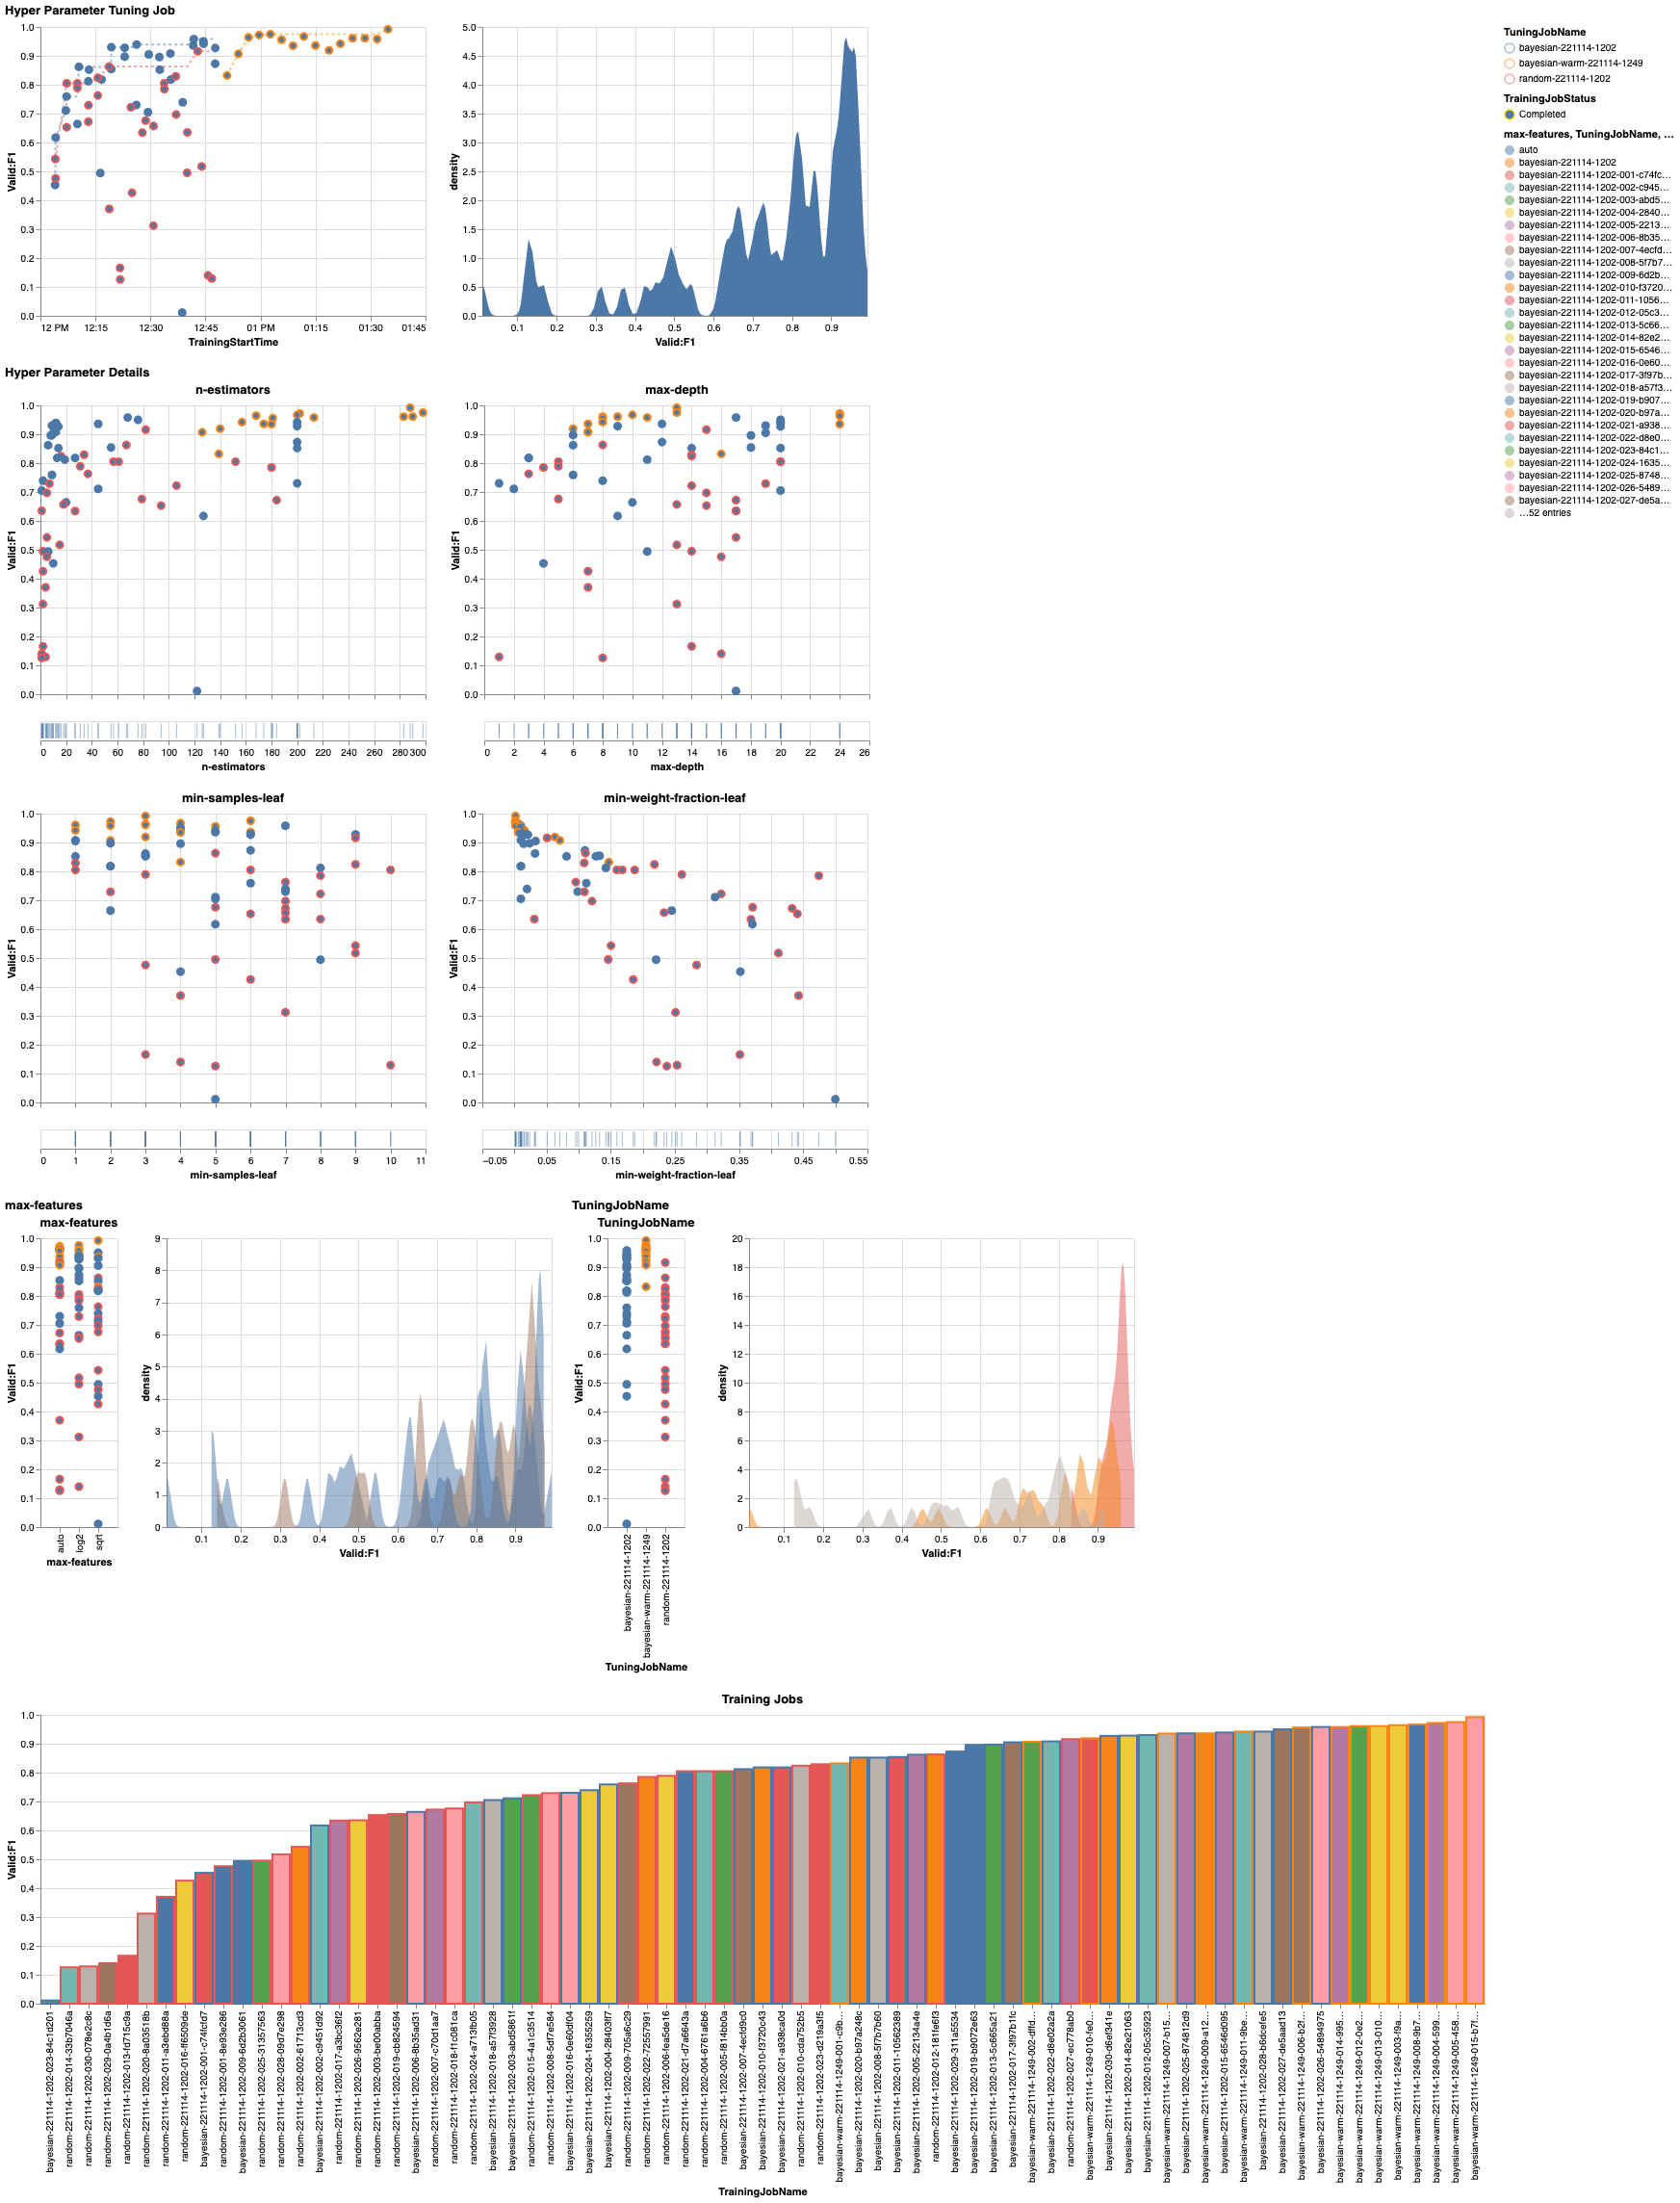

In [29]:
visualize_tuning_job(warmstarted_tuner, advanced=True, trials_only=True)

## Please Note

As it turns out to use the existing knowledge in our heads (the understanding of hyper parameter value ranges) together with the captured knowledge in SageMaker Automatic Model Tuning (the previous trials that we now use using warmstart), we were able to continue to improve on the objective. And the overall result was much better. 

Also, recognize above how SageMaker HPO pre-dominantly probed the areas that were previously unexplored. The data points with the orange outline belong to the second optimization run.

### Open:
    
- Early Stopping?